# Logisticka regresija

### Predvidjanje da li cena BTC raste/opada na kraju dana koriscenjem modela Logisticke regresije

### Ucitavanje biblioteka

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

%run Preprocessing.ipynb
#%run Utility.ipynb

### Ucitavanje skupa podataka

In [15]:
data = preprocess_data(file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01


In [16]:
# Dimenzije skupa podataka

data.shape

(3613769, 9)

### Filtriranje kolona

In [17]:
data_ = data.drop(['Volume_(BTC)','Volume_(Currency)','Weighted_Price'], axis=1)
data_.head()

,Timestamp,Open,High,Low,Close,Date
0,1325317920,4.39,4.39,4.39,4.39,2011-12-31
478,1325346600,4.39,4.39,4.39,4.39,2011-12-31
547,1325350740,4.50,4.57,4.50,4.57,2011-12-31
548,1325350800,4.58,4.58,4.58,4.58,2011-12-31
1224,1325391360,4.58,4.58,4.58,4.58,2012-01-01


### Dodavanje kolone sa indeksom

In [18]:
#data_["row_id"] = range(1, len(data_) + 1)

In [19]:
#data_.set_index('row_id', inplace=True)
#data_.head()

### Razlika vrednosti na otvaranju i vrednosti na zatvaranju

In [20]:
# Dodavanje novog atributa (kolone) 'pos_neg' koji
# predstavlja razliku otvarajuce i zatvarajuce
# vrednosti (cene) bitkoina za taj dan

data_['pos_neg'] = data_['Close']-data_['Open']
data_.head()

# Na osnovu prethodno dodatog atributa, moze se
# videti da li se instanca, odnosno dan zatvorio
# sa porastom vrednosti ili sa padom vrednosti

,Timestamp,Open,High,Low,Close,Date,pos_neg
0,1325317920,4.39,4.39,4.39,4.39,2011-12-31,0.00
478,1325346600,4.39,4.39,4.39,4.39,2011-12-31,0.00
547,1325350740,4.50,4.57,4.50,4.57,2011-12-31,0.07
548,1325350800,4.58,4.58,4.58,4.58,2011-12-31,0.00
1224,1325391360,4.58,4.58,4.58,4.58,2012-01-01,0.00


In [21]:
# Dodavanje novog atributa 'Up/Down' koji ce biti
# ciljna (target) promenljiva - koju treba predvideti

# Atribut 'Up/Down' je binarna kolona cije vrednosti
# mogu biti:
# 0 = gubitak (pad cene)
# 1 = dobitak (rast cene)

data_['Up/Down'] = np.where(data_['pos_neg']>0, 1, 0)
data_.tail()

,Timestamp,Open,High,Low,Close,Date,pos_neg,Up/Down
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,2021-03-30,-28.31,0
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,2021-03-30,1.84,1
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,2021-03-30,30.41,1
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,2021-03-30,18.41,1
4857376,1617148800,58767.75,58778.18,58755.97,58778.18,2021-03-31,10.43,1


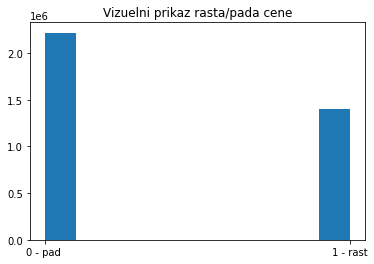

In [22]:
# Vizuelni prikaz rasta/pada cene

plt.title('Vizuelni prikaz rasta/pada cene')
plt.hist(data_['Up/Down'])
plt.xticks(np.arange(0, 2), ['0 - pad ', '1 - rast'], rotation='horizontal')

plt.show()

In [23]:
data_ = data_.drop('Timestamp',axis=1)
data_.head()

,Open,High,Low,Close,Date,pos_neg,Up/Down
0,4.39,4.39,4.39,4.39,2011-12-31,0.00,0
478,4.39,4.39,4.39,4.39,2011-12-31,0.00,0
547,4.50,4.57,4.50,4.57,2011-12-31,0.07,1
548,4.58,4.58,4.58,4.58,2011-12-31,0.00,0
1224,4.58,4.58,4.58,4.58,2012-01-01,0.00,0


In [24]:
data_.shape

(3613769, 7)

### Stratifikovana podela skupa podataka na skup za treniranje i skup za testiranje u datoj razmeri.

In [35]:
X = data_[['Open', 'High', 'Low','Close']]
y = data_['Up/Down']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=101, stratify = y)

In [36]:
# vise je ne-nula elemenata, kao sto je i ocekivano
y.shape, np.count_nonzero(y, axis=0)

((3613769,), 1396868)

In [37]:
non_zero_train = np.count_nonzero(y_train, axis=0) # ne-nula
zero_train = y_train.shape[0] - non_zero_train # nula
print('Jedinice: ', non_zero_train, 'Nule: ', zero_train)

Jedinice:  977807 Nule:  1551831


In [38]:
non_zero_test = np.count_nonzero(y_test, axis=0) # ne-nula
zero_test = y_test.shape[0] - non_zero_test # nula
print('Jedinice: ', non_zero_test, 'Nule: ', zero_test)

Jedinice:  419061 Nule:  665070


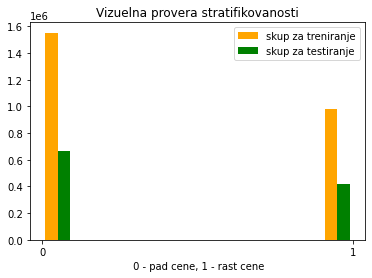

In [39]:
plt.title("Vizuelna provera stratifikovanosti")
plt.xticks([0,1])
plt.xlabel(' 0 - pad cene, 1 - rast cene')
plt.hist([y_train, y_test], color=['orange', 'green'], label=['skup za treniranje', 'skup za testiranje'])
plt.legend(loc='best')
plt.show()

### Skaliranje

In [40]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Kreiranje i treniranje modela.

In [41]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

### Predvidjanje modela.

In [42]:
predictions = logmodel.predict(X_test)
train_predictions = logmodel.predict(X_train)

### Tacnost na skupovima za treniranje i testiranje.

In [43]:
train_score = metrics.accuracy_score(y_train, train_predictions)
test_score = metrics.accuracy_score(y_test, predictions)
print("Tacnost na skupu za treniranje: {train}\nTacnost na skupu za testiranje: {test}".format(train=train_score, test=test_score))

Tacnost na skupu za treniranje: 0.6141420234832019
Tacnost na skupu za testiranje: 0.6139571693826669


### Ostale mere na skupu za testiranje.

In [44]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.62      0.97      0.75    665070
           1       0.51      0.05      0.09    419061

    accuracy                           0.61   1084131
   macro avg       0.56      0.51      0.42   1084131
weighted avg       0.58      0.61      0.50   1084131



### Matrica konfuzije.

In [45]:
confusion_m = metrics.confusion_matrix(y_test, predictions)
confusion_m

array([[644723,  20347],
       [398174,  20887]], dtype=int64)

In [46]:
tp = confusion_m[0][0]
tp

644723

In [47]:
fp = confusion_m[0][1]
fp

20347

In [48]:
fn = confusion_m[1][0]
fn

398174

In [49]:
tn = confusion_m[1][1]
tn

20887

### Analiza sigurnosti klasifikatora.

In [50]:
first_ten_predictions = predictions[0:10]
first_ten_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [51]:
# verovatnoce da instance pripadaju pozitivnoj odnosno negativnoj klasi
predictions_probabilities = logmodel.predict_proba(X_test)
predictions_probabilities[0:10]

array([[0.60099368, 0.39900632],
       [0.52790533, 0.47209467],
       [0.64320498, 0.35679502],
       [0.64546859, 0.35453141],
       [0.64847595, 0.35152405],
       [0.61097642, 0.38902358],
       [0.64708609, 0.35291391],
       [0.61080313, 0.38919687],
       [0.61147395, 0.38852605],
       [0.64690013, 0.35309987]])

In [52]:
logmodel_confidence = []

for p in predictions_probabilities: 
    logmodel_confidence.append(np.abs(p[0]-p[1]))
    
logmodel_confidence = np.array(logmodel_confidence)

In [53]:
# indeksi instanci uredjeni na osnovu sigurnosti klasifikatora u svoju odluku
# pocev od indeksa instanci oko cije klasifikacije je klasifikator najmanje siguran
logmodel_confidence.argsort()

array([ 928531,  704863,  703469, ...,  258271,  941290, 1031620],
      dtype=int64)

In [54]:
# uredjeni niz razlike verovatnoca pocev od onih koji se
# najmanje razlikuju ka onim koji se najvise razlikuju
logmodel_confidence.sort()
logmodel_confidence

array([8.95593956e-06, 1.96090701e-05, 2.07362668e-05, ...,
       5.02240550e-01, 5.10088952e-01, 5.70127445e-01])